In [6]:
#!pip install stockstats

In [62]:
import requests
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import pi

from stockstats import StockDataFrame



# Read in Daily Historical Crypto Price

In [86]:
def daily_price_historical(symbol, comparison_symbol, all_data=True, exchange=''):
    '''
    :params symbol: srt cryptoasset ticker e.x. BTC
    :params comparison_symbol: str ticker to compare to e.x. USD
    :params all_data: bool get all data
    :params limit: int rate limit
    :params aggregate: int increment to aggregate
    :params exchange: str token exchange ticker
    
    :returns pandas dataframe
    
    Accesses the CryptoCompare API and returns a pandas dataframe of all historical data
    '''
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&all_data={}'\
            .format(symbol.upper(), comparison_symbol.upper(),all_data)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

In [87]:
symbol = "BTC"
comparison_symbol = "USD"
df = daily_price_historical(symbol, comparison_symbol)
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,0.9902,2010-07-16 20:00:00
1,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.0900,2010-07-17 20:00:00
2,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,49.6600,2010-07-18 20:00:00
3,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,20.5900,2010-07-19 20:00:00
4,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,42.2600,2010-07-20 20:00:00


In [88]:
start_date = pd.to_datetime('2018-02-01')
mask = (df['timestamp'] > start_date)
df = df.loc[mask]
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp
2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-01 19:00:00
2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00
2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00
2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00
2761,7701.25,7932.38,5968.36,6936.43,1517875200,495883.24,3.397597e+09,2018-02-05 19:00:00


# Moving Average

In [180]:
df['ema'] = df.get('close_10_ema')
df.head()

,level_0,index,close,high,low,open,time,volumefrom,volumeto,timestamp,...,close_-1_d,rs_14,rsi_14,rsi,rsi_signal,close_6_ema,ema,close_7_ema,close_14_ema,close_10_ema
0,0,2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-01 19:00:00,...,NaN,NaN,NaN,NaN,No Move,8870.820000,8870.820000,8870.820000,8870.820000,8870.820000
1,1,2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,...,380.45,inf,100.000000,100.000000,Buy,9092.749167,9080.067500,9088.220000,9074.632500,9080.067500
2,2,2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,...,-1033.22,0.341917,25.479717,25.479717,Sell,8699.535780,8733.542193,8711.930270,8747.415076,8733.542193
3,3,2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00,...,-1280.97,0.146422,12.772048,12.772048,Sell,8018.767387,8141.687941,8062.842171,8193.582509,8141.687941
4,4,2761,7701.25,7932.38,5968.36,6936.43,1517875200,495883.24,3.397597e+09,2018-02-05 19:00:00,...,764.17,0.513747,33.938772,33.938772,No Move,7907.327649,8015.250187,7944.317721,8065.133711,8015.250187


In [181]:
df['sma'] = df.get('close_10_sma')
df.head()

,level_0,index,close,high,low,open,time,volumefrom,volumeto,timestamp,...,rsi_14,rsi,rsi_signal,close_6_ema,ema,close_7_ema,close_14_ema,close_10_ema,close_10_sma,sma
0,0,2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-01 19:00:00,...,NaN,NaN,No Move,8870.820000,8870.820000,8870.820000,8870.820000,8870.820000,8870.820000,8870.820000
1,1,2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,...,100.000000,100.000000,Buy,9092.749167,9080.067500,9088.220000,9074.632500,9080.067500,9061.045000,9061.045000
2,2,2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,...,25.479717,25.479717,Sell,8699.535780,8733.542193,8711.930270,8747.415076,8733.542193,8780.046667,8780.046667
3,3,2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00,...,12.772048,12.772048,Sell,8018.767387,8141.687941,8062.842171,8193.582509,8141.687941,8319.305000,8319.305000
4,4,2761,7701.25,7932.38,5968.36,6936.43,1517875200,495883.24,3.397597e+09,2018-02-05 19:00:00,...,33.938772,33.938772,No Move,7907.327649,8015.250187,7944.317721,8065.133711,8015.250187,8195.694000,8195.694000


# MACD (Moving Average Convergence Divergence)

In [89]:
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd')
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp,close_12_ema,close_26_ema,macd,macds,macdh
2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-01 19:00:00,8870.820000,8870.820000,0.000000,0.000000,0.000000
2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,9076.897083,9068.361346,8.535737,4.742076,7.587322
2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,8741.688868,8762.852735,-21.163867,-5.875114,-30.577507
2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00,8172.044374,8252.446464,-80.402090,-31.121379,-98.561422
2761,7701.25,7932.38,5968.36,6936.43,1517875200,495883.24,3.397597e+09,2018-02-05 19:00:00,8044.131225,8124.621731,-80.490506,-45.807578,-69.365855


In [90]:
print(df.iloc[0,10])
print(df.iloc[0,11])

0.0
0.0


- close_12_ema is fast 12 days exponential moving average,
- close_26_ema is slow 26 days exponential moving average,
- macd is MACD line,
- macds is signal line,
- macdh is MACD histogram.


In [91]:
%matplotlib inline

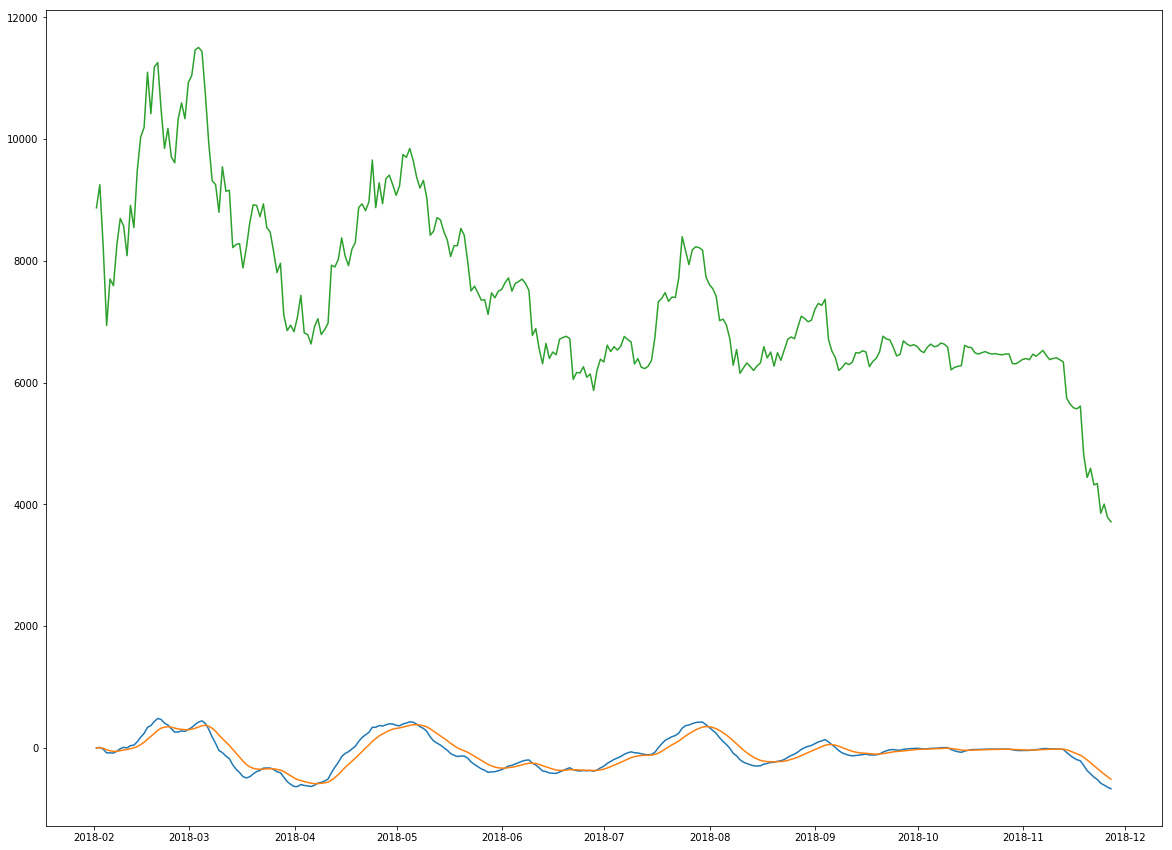

In [92]:
plt.figure(figsize = (20,15))
plt.plot('timestamp', 'macd', data = df)
plt.plot('timestamp', 'macds', data = df)
plt.plot('timestamp', 'close', data = df)

# MACD Backtest

In [93]:
def crossover(df, idx):
    if idx == 0:
        return("No Crossover")
    #print(df.head())
    prev_macd = df.iloc[idx-1, 10]
    prev_signal = df.iloc[idx-1, 11]
    current_macd = df.iloc[idx, 10]
    current_signal = df.iloc[idx, 11]
        
    if prev_signal < prev_macd and current_macd <= current_signal: # bearish crossover
        return("Bearish")
    elif prev_signal > prev_macd and current_macd >= current_signal: # bullish crossover
        return("Bullish")
    else: # no crossover
        return("No Crossover")

In [94]:
c = []
for x in range(len(df['timestamp'])):
    c.append(crossover(df,x))

In [95]:
c = pd.Series(c)
c.head()

0    No Crossover
1    No Crossover
2         Bearish
3    No Crossover
4    No Crossover
dtype: object

In [96]:
df = df.assign(crossover=c.values)

In [97]:
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp,close_12_ema,close_26_ema,macd,macds,macdh,crossover
2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-01 19:00:00,8870.820000,8870.820000,0.000000,0.000000,0.000000,No Crossover
2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,9076.897083,9068.361346,8.535737,4.742076,7.587322,No Crossover
2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,8741.688868,8762.852735,-21.163867,-5.875114,-30.577507,Bearish
2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00,8172.044374,8252.446464,-80.402090,-31.121379,-98.561422,No Crossover
2761,7701.25,7932.38,5968.36,6936.43,1517875200,495883.24,3.397597e+09,2018-02-05 19:00:00,8044.131225,8124.621731,-80.490506,-45.807578,-69.365855,No Crossover


In [98]:
mask = (df['crossover'] == 'Bullish') | (df['crossover'] == 'Bearish')
cross_df = df.loc[mask]
cross_df.head()
    

,close,high,low,open,time,volumefrom,volumeto,timestamp,close_12_ema,close_26_ema,macd,macds,macdh,crossover
2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,8741.688868,8762.852735,-21.163867,-5.875114,-30.577507,Bearish
2763,8260.69,8643.94,7590.48,7593.78,1518048000,193040.33,1.594674e+09,2018-02-07 19:00:00,8007.221774,8061.231910,-54.010136,-55.549307,3.078342,Bullish
2779,9705.73,10528.00,9396.54,10175.51,1519430400,125269.68,1.244484e+09,2018-02-23 19:00:00,10029.966223,9713.536759,316.429465,342.017454,-51.175978,Bearish
2784,10929.37,11090.30,10247.56,10334.44,1519862400,88432.44,9.524721e+08,2018-02-28 19:00:00,10266.914144,9961.276847,305.637297,300.715675,9.843243,Bullish
2790,9928.56,10913.70,9470.73,10735.45,1520380800,183060.08,1.858869e+09,2018-03-06 19:00:00,10668.172038,10362.377584,305.794454,358.689152,-105.789394,Bearish


In [99]:
cross_df = cross_df[['close', 'high', 'low', 'open']]
cross_df.head()

,close,high,low,open
2759,8218.05,9400.99,7889.83,9251.27
2763,8260.69,8643.94,7590.48,7593.78
2779,9705.73,10528.00,9396.54,10175.51
2784,10929.37,11090.30,10247.56,10334.44
2790,9928.56,10913.70,9470.73,10735.45


In [100]:
returns_df = cross_df.pct_change()
returns_df

,close,high,low,open
2759,NaN,NaN,NaN,NaN
2763,0.005189,-0.080529,-0.037941,-0.179164
2779,0.174930,0.217963,0.237938,0.339980
2784,0.126074,0.053410,0.090567,0.015619
2790,-0.091571,-0.015924,-0.075806,0.038803
2806,-0.100091,-0.181224,-0.122815,-0.187274
2809,-0.087590,-0.046424,-0.052760,-0.028931
2822,-0.135213,-0.163009,-0.121771,-0.183576
2852,0.304430,0.328106,0.311394,0.355618
2877,-0.168861,-0.187366,-0.176020,-0.196920


In [101]:
trade_sum = returns_df['close'].sum()
print('Trade Sum: {}'.format(trade_sum))
if trade_sum > 0:
    print('Positive Return!')
elif trade_sum < 0:
    print('Negative Return!')
else:
    print('No Return!')

Trade Sum: -0.10795147305869257
Negative Return!


# RSI (Relative Strength Index)

In [182]:
df['rsi'] = df.get('rsi')
df.head()

,level_0,index,close,high,low,open,time,volumefrom,volumeto,timestamp,...,rsi_14,rsi,rsi_signal,close_6_ema,ema,close_7_ema,close_14_ema,close_10_ema,close_10_sma,sma
0,0,2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-01 19:00:00,...,NaN,NaN,No Move,8870.820000,8870.820000,8870.820000,8870.820000,8870.820000,8870.820000,8870.820000
1,1,2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,...,100.000000,100.000000,Buy,9092.749167,9080.067500,9088.220000,9074.632500,9080.067500,9061.045000,9061.045000
2,2,2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,...,25.479717,25.479717,Sell,8699.535780,8733.542193,8711.930270,8747.415076,8733.542193,8780.046667,8780.046667
3,3,2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00,...,12.772048,12.772048,Sell,8018.767387,8141.687941,8062.842171,8193.582509,8141.687941,8319.305000,8319.305000
4,4,2761,7701.25,7932.38,5968.36,6936.43,1517875200,495883.24,3.397597e+09,2018-02-05 19:00:00,...,33.938772,33.938772,No Move,7907.327649,8015.250187,7944.317721,8065.133711,8015.250187,8195.694000,8195.694000


In [124]:
def rsi_signal(rsi):
    
    try:
        #print(rsi)
        if rsi >= 70: # Buy signal
            return("Buy")
        elif rsi <= 30: # Sell signal
            return("Sell")
        else:
            return("No Move")
    except Exception as e:
        print(e)
        return("No Crossover")

In [125]:
df['rsi_signal'] = df.apply(lambda x: rsi_signal(x['rsi']), axis = 1)
df.head()

,level_0,index,close,high,low,open,time,volumefrom,volumeto,timestamp,...,macd,macds,macdh,crossover,close_-1_s,close_-1_d,rs_14,rsi_14,rsi,rsi_signal
0,0,2757,8870.82,9147.93,7786.20,9114.73,1517529600,322596.22,2.768760e+09,2018-02-01 19:00:00,...,0.000000,0.000000,0.000000,No Crossover,NaN,NaN,NaN,NaN,NaN,No Move
1,1,2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,...,8.535737,4.742076,7.587322,No Crossover,8870.82,380.45,inf,100.000000,100.000000,Buy
2,2,2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,...,-21.163867,-5.875114,-30.577507,Bearish,9251.27,-1033.22,0.341917,25.479717,25.479717,Sell
3,3,2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00,...,-80.402090,-31.121379,-98.561422,No Crossover,8218.05,-1280.97,0.146422,12.772048,12.772048,Sell
4,4,2761,7701.25,7932.38,5968.36,6936.43,1517875200,495883.24,3.397597e+09,2018-02-05 19:00:00,...,-80.490506,-45.807578,-69.365855,No Crossover,6937.08,764.17,0.513747,33.938772,33.938772,No Move


In [132]:
mask = (df['rsi_signal'] == 'Buy') | (df['rsi_signal'] == 'Sell')
rsi_df = df.loc[mask]
rsi_df.head()
    

,level_0,index,close,high,low,open,time,volumefrom,volumeto,timestamp,...,macd,macds,macdh,crossover,close_-1_s,close_-1_d,rs_14,rsi_14,rsi,rsi_signal
1,1,2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,...,8.535737,4.742076,7.587322,No Crossover,8870.82,380.45,inf,100.000000,100.000000,Buy
2,2,2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,...,-21.163867,-5.875114,-30.577507,Bearish,9251.27,-1033.22,0.341917,25.479717,25.479717,Sell
3,3,2760,6937.08,8391.29,6627.31,8218.05,1517788800,341828.54,2.534149e+09,2018-02-04 19:00:00,...,-80.402090,-31.121379,-98.561422,No Crossover,8218.05,-1280.97,0.146422,12.772048,12.772048,Sell
15,15,2772,11097.21,11119.45,10074.07,10188.73,1518825600,123660.48,1.327921e+09,2018-02-16 19:00:00,...,338.291163,143.422880,389.736564,No Crossover,10188.73,908.48,2.394006,70.536290,70.536290,Buy
130,130,2887,6556.94,6888.33,6462.61,6887.43,1528761600,75997.29,5.093725e+08,2018-06-11 20:00:00,...,-325.428118,-269.425206,-112.005824,No Crossover,6887.37,-330.43,0.410493,29.102784,29.102784,Sell


In [136]:
rsi_df['rsi_signal']

1       Buy
2      Sell
3      Sell
15      Buy
130    Sell
131    Sell
172     Buy
173     Buy
285    Sell
286    Sell
287    Sell
288    Sell
289    Sell
290    Sell
291    Sell
292    Sell
293    Sell
294    Sell
295    Sell
296    Sell
297    Sell
298    Sell
Name: rsi_signal, dtype: object

In [170]:
def remove_rsi_duplicates(df):
    other_df = df.iloc[0:1]
    print(type(other_df))
    prev_signal = 'Buy'
    for index, row in df.iterrows():
        #print(type(row))
        #if row['rsi_signal'] == 'Buy' and prev_signal == '':
         #   prev_signal = 'Buy'
          #  other_df = other_df.append(row, ignore_index = True)
        if row['rsi_signal'] == 'Sell' and prev_signal == 'Buy':
            prev_signal = 'Sell'
            other_df = other_df.append(row, ignore_index = True)
        elif row['rsi_signal'] == 'Buy' and prev_signal == 'Sell':
            prev_signal = 'Buy'
            other_df = other_df.append(row, ignore_index = True)
    return other_df

In [172]:
other_rsi = remove_rsi_duplicates(rsi_df)
other_rsi

<class 'pandas.core.frame.DataFrame'>


,level_0,index,close,high,low,open,time,volumefrom,volumeto,timestamp,...,macd,macds,macdh,crossover,close_-1_s,close_-1_d,rs_14,rsi_14,rsi,rsi_signal
0,1,2758,9251.27,9504.37,8194.68,8872.87,1517616000,139226.07,1.253485e+09,2018-02-02 19:00:00,...,8.535737,4.742076,7.587322,No Crossover,8870.82,380.45,inf,100.000000,100.000000,Buy
1,2,2759,8218.05,9400.99,7889.83,9251.27,1517702400,164609.06,1.413207e+09,2018-02-03 19:00:00,...,-21.163867,-5.875114,-30.577507,Bearish,9251.27,-1033.22,0.341917,25.479717,25.479717,Sell
2,15,2772,11097.21,11119.45,10074.07,10188.73,1518825600,123660.48,1.327921e+09,2018-02-16 19:00:00,...,338.291163,143.422880,389.736564,No Crossover,10188.73,908.48,2.394006,70.536290,70.536290,Buy
3,130,2887,6556.94,6888.33,6462.61,6887.43,1528761600,75997.29,5.093725e+08,2018-06-11 20:00:00,...,-325.428118,-269.425206,-112.005824,No Crossover,6887.37,-330.43,0.410493,29.102784,29.102784,Sell
4,172,2929,8395.82,8485.71,7692.16,7718.00,1532390400,143800.43,1.166561e+09,2018-07-23 20:00:00,...,324.052283,155.220965,337.662637,No Crossover,7718.00,677.82,3.397414,77.259364,77.259364,Buy
5,285,3042,5741.47,6375.70,5469.93,6339.17,1542153600,178422.80,1.045469e+09,2018-11-13 19:00:00,...,-75.085333,-31.399924,-87.370818,No Crossover,6339.17,-597.70,0.261290,20.716119,20.716119,Sell


In [173]:
other_rsi = other_rsi[['close', 'high', 'low', 'open']]

In [174]:
other_rsi

,close,high,low,open
0,9251.27,9504.37,8194.68,8872.87
1,8218.05,9400.99,7889.83,9251.27
2,11097.21,11119.45,10074.07,10188.73
3,6556.94,6888.33,6462.61,6887.43
4,8395.82,8485.71,7692.16,7718.00
5,5741.47,6375.70,5469.93,6339.17


In [175]:
returns_rsi = other_rsi.pct_change()
returns_rsi

,close,high,low,open
0,NaN,NaN,NaN,NaN
1,-0.111684,-0.010877,-0.037201,0.042647
2,0.350346,0.182796,0.276842,0.101333
3,-0.409136,-0.380515,-0.358491,-0.324015
4,0.280448,0.231897,0.190256,0.120592
5,-0.316151,-0.248655,-0.288895,-0.178651


In [176]:
trade_sum = returns_rsi['close'].sum()
print('Trade Sum: {}'.format(trade_sum))
if trade_sum > 0:
    print('Positive Return!')
elif trade_sum < 0:
    print('Negative Return!')
else:
    print('No Return!')

Trade Sum: -0.20617788953175475
Negative Return!
